In [1]:
import torch
from ultralytics import YOLO

In [2]:
model = torch.jit.load('runs/detect/train_100_epochs/weights/best.torchscript')# Load the 100-epoch TorchScript model using PyTorch
model.eval()  # Set the model to evaluation mode

RecursiveScriptModule(
  original_name=DetectionModel
  (model): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Conv
      (conv): RecursiveScriptModule(original_name=Conv2d)
      (act): RecursiveScriptModule(original_name=SiLU)
    )
    (1): RecursiveScriptModule(
      original_name=Conv
      (conv): RecursiveScriptModule(original_name=Conv2d)
      (act): RecursiveScriptModule(original_name=SiLU)
    )
    (2): RecursiveScriptModule(
      original_name=C3k2
      (cv1): RecursiveScriptModule(
        original_name=Conv
        (conv): RecursiveScriptModule(original_name=Conv2d)
        (act): RecursiveScriptModule(original_name=SiLU)
      )
      (cv2): RecursiveScriptModule(
        original_name=Conv
        (conv): RecursiveScriptModule(original_name=Conv2d)
        (act): RecursiveScriptModule(original_name=SiLU)
      )
      (m): RecursiveScriptModule(
        original_name=ModuleList
        (0): RecursiveScriptMod

In [3]:
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

image_path = '5_jpg.rf.52eb3d30932a0b4b8ecb54336b7568ba.jpg'# Load and preprocess the image
image = Image.open(image_path).convert('RGB')
transform = transforms.Compose([# Preprocessing: resize, normalize, and convert to tensor
    transforms.Resize((640, 640)),  # resize to model's expected input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

In [4]:
with torch.no_grad():# Disable gradient calculation for faster inference
    output = model(input_tensor)

Boxes: tensor([[341.7252, 111.7750, 131.4070, 101.5597],
        [343.5157, 113.3052, 129.2559, 106.7588],
        [342.8204, 112.6772, 129.5135, 106.3805],
        [341.8207, 112.2684, 130.4289, 100.9743],
        [342.4004, 110.8909, 131.6535,  99.4458]])
Scores: tensor([0.4612, 0.4227, 0.3876, 0.3832, 0.2567])
Labels: tensor([0, 0, 0, 0, 0], dtype=torch.int32)


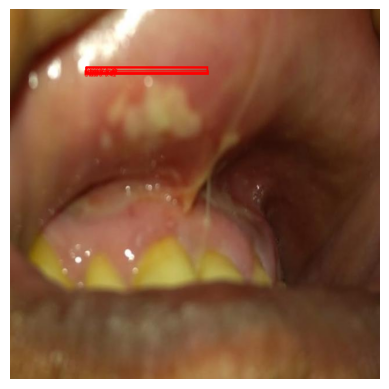

In [5]:
confidence_threshold = 0.25
nms_threshold = 0.4
def process_output(output, conf_threshold, nms_threshold):
    output = output[0]  # Remove the batch dimension, resulting in shape [6, 8400]
    boxes = torch.stack((output[0], output[1], output[2], output[3]), dim=1)  # Shape [8400, 4], # Extract bounding boxes, scores, and labels
    scores = output[4]  # Shape [8400], confidence scores
    labels = output[5].int()  # Shape [8400], class labels (converted to integers for class indices)
    mask = scores > conf_threshold # Filter boxes with confidence above the threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    keep = torchvision.ops.nms(boxes, scores, nms_threshold) # Apply NMS
    return boxes[keep], scores[keep], labels[keep]
boxes, scores, labels = process_output(output, confidence_threshold, nms_threshold)# Process the model output
print("Boxes:", boxes)# Display or use the results
print("Scores:", scores)
print("Labels:", labels)
def plot_detections(image_path, boxes, scores, labels, confidence_threshold=0.25):
    image = Image.open(image_path)# Open the image
    draw = ImageDraw.Draw(image)
    for box, score, label in zip(boxes, scores, labels):
        if score >= confidence_threshold:
            x1, y1, x2, y2 = box.tolist()# Correct the order of coordinates
            x0, x1 = min(x1, x2), max(x1, x2)
            y0, y1 = min(y1, y2), max(y1, y2)
            draw.rectangle([x0, y0, x1, y1], outline="red", width=2)# Draw the bounding box
            draw.text((x0, y0), f"Class {label}: {score:.2f}", fill="red")# Add a label with the score
    plt.imshow(image)# Show the image with detections
    plt.axis("off")
    plt.show()
image_path = "5_jpg.rf.52eb3d30932a0b4b8ecb54336b7568ba.jpg"#'image_path' is the path to your input image
plot_detections(image_path, boxes, scores, labels)